In [8]:
import vectorbtpro as vbt
import ttools as tts
from lightweight_charts import chart, Panel, PlotDFAccessor, PlotSRAccessor
#import talib
import ttools as tts
from ttools.config import DATA_DIR
from ttools.utils import zoneNY, AggType
from ttools.loaders import load_data
from numba import jit
import pandas as pd
import numpy as np
from datetime import datetime
vbt.settings.plotting.auto_rangebreaks = True
vbt.settings.set_theme("dark")
vbt.settings.plotting["use_resampler"] = True
from traceback import format_exc
from vectorbtpro.utils.config import merge_dicts, Config, HybridConfig
from vectorbtpro import _typing as tp
from vectorbtpro.generic import nb as generic_nb

_feature_config: tp.ClassVar[Config] = HybridConfig(
    {
        "buyvolume": dict(
            resample_func=lambda self, obj, resampler: obj.vbt.resample_apply(
                resampler,
                generic_nb.sum_reduce_nb,
            )
        ),
        "sellvolume": dict(
            resample_func=lambda self, obj, resampler: obj.vbt.resample_apply(
                resampler,
                generic_nb.sum_reduce_nb,
            )
        ),
        "trades": dict(
            resample_func=lambda self, obj, resampler: obj.vbt.resample_apply(
                resampler,
                generic_nb.sum_reduce_nb,
            )
        )
    }
)

In [9]:

#This is how to call LOAD function
symbol = ["BAC"]
#datetime in zoneNY 
day_start = datetime(2024, 8, 10, 9, 30, 0)
day_stop = datetime(2024, 10, 20, 16, 0, 0)
day_start = zoneNY.localize(day_start)
day_stop = zoneNY.localize(day_stop)

#requested AGG
resolution = 20000 #10min bars #12s bars
agg_type = AggType.OHLCV_VOL #other types AggType.OHLCV_VOL, AggType.OHLCV_DOL, AggType.OHLCV_RENKO
exclude_conditions = ['C','O','4','B','7','V','P','W','U','Z','F','9','M','6'] #None to defaults
minsize = 100 #min trade size to include
main_session_only = True
force_remote = False

bac_data = load_data(symbol = symbol,
                     agg_type = agg_type,
                     resolution = resolution,
                     start_date = day_start,
                     end_date = day_stop,
                     #exclude_conditions = None,
                     minsize = minsize,
                     main_session_only = main_session_only,
                     force_remote = force_remote,
                     return_vbt = False, #returns vbt object
                     verbose = True
                     )
df = bac_data["BAC"]

matched agg files 1

File: BAC-AggType.OHLCV_VOL-20000-2024-08-01T09-30-00-2024-10-20T16-00-00-4679BCFMOPUVWZ-100-True.parquet
Coverage: 2024-08-01 09:30:00 to 2024-10-20 16:00:00
Symbol: BAC
Agg Type: AggType.OHLCV_VOL
Resolution: 20000
Excludes: 4679BCFMOPUVWZ
Minsize: 100
Main Session Only: True
--------------------------------------------------------------------------------
Loaded from agg_cache /Users/davidbrazda/Library/Application Support/v2realbot/aggcache/BAC-AggType.OHLCV_VOL-20000-2024-08-01T09-30-00-2024-10-20T16-00-00-4679BCFMOPUVWZ-100-True.parquet


In [ ]:
#df.loc["2024-10-01":"2024-10-02"].lw.plot()
df.head(50)

In [14]:
from abc import ABC, abstractmethod
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Tuple
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
from lightweight_charts import Panel, chart, PlotDFAccessor, PlotSRAccessor
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
warnings.filterwarnings('ignore')
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp

@dataclass
class ModelConfig:
    """Configuration for the trading model"""
    train_days: int = 10
    test_days: int = 1
    forward_bars: int = 5
    model_type: str = 'classifier'
    n_classes: int = 3
    ma_lengths: List[int] = field(default_factory=lambda: [5, 10, 20, 50])
    warm_up_period: int = None # Number of bars to attach before test period
    features_fib_max_lookback: pd.Timedelta = pd.Timedelta(hours=1) # maximum features lookback
    features_fib_max_windows: int = None # limit features windows sizes to certain count
    optuna_trials:int = 3
    summary_analysis_profit_th: float = 1
    summary_per_iteration: bool = True
    summary_slippage_pct: float = 0.1

class BaseFeatureBuilder(ABC):
    """Abstract base class for feature engineering"""
    
    def __init__(self, config: ModelConfig):
        self.config = config
        self.generated_features = set()
        
    @abstractmethod
    def prepare_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Build features from input data"""
        pass
    
    def get_feature_descriptions(self) -> dict:
        """Return descriptions of features"""
        return self._feature_descriptions
    
    @abstractmethod
    def create_target(self, df: pd.DataFrame, train_data: Optional[pd.DataFrame] = None) -> pd.Series:
        """Creates target variables"""
        pass
        

class TechnicalFeatureBuilder(BaseFeatureBuilder):
    """Technical feature implementation"""
    
    def __init__(self, config: ModelConfig):
        super().__init__(config)
        self.class_boundaries = None
        
    def prepare_features(self, df: pd.DataFrame) -> tuple[pd.DataFrame, list]:
        """Prepare enhanced features from input df with focus on predictive potential"""
        features = pd.DataFrame(index=df.index)

        # Original ohlcv added to features
        features['close'] = df['close']
        features['volume'] = df['volume']
        features['trades_count'] = df['trades']
        features['buy_volume'] = df['buyvolume']
        features['sell_volume'] = df['sellvolume']
        features['high'] = df['high']
        features['low'] = df['low']
        # features['log_return'] = np.log(features['close'] / features['close'].shift(1))
        # features['returns_1'] = features['close'].pct_change()
        # features['returns_5'] = features['close'].pct_change(5)
        # features['returns_20'] = features['close'].pct_change(20)


        def get_fib_windows(bar_frequency: pd.Timedelta, 
                            max_time_lookback: pd.Timedelta,
                            n_windows: int = None) -> list[int]:
            """
            Generate Fibonacci sequence windows scaled to the bar frequency up to max_time_lookback.
            
            Parameters:
            -----------
            bar_frequency : pd.Timedelta
                The frequency of the input bars (e.g., pd.Timedelta(seconds=1) or pd.Timedelta(minutes=5))
            max_time_lookback : pd.Timedelta
                Maximum lookback period to generate windows for
            n_windows : int, optional
                If specified, returns exactly n_windows Fibonacci-spaced periods up to max_time_lookback
                
            Returns:
            --------
            list[int]
                List of integers representing the number of bars to look back
                
            Examples:
            --------
            # For 1-minute bars, 1-hour lookback
            >>> get_fib_windows(pd.Timedelta(minutes=1), pd.Timedelta(hours=1))
            [3, 5, 8, 13, 21, 34, 55]
            
            # For 1-second bars, 1-hour lookback
            >>> get_fib_windows(pd.Timedelta(seconds=1), pd.Timedelta(hours=1))
            [3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584]
            
            # For 5-minute bars, 4-hour lookback, exactly 5 windows
            >>> get_fib_windows(pd.Timedelta(minutes=5), pd.Timedelta(hours=4), n_windows=5)
            [3, 5, 8, 13, 21]
            """
            # Convert max_time_lookback to number of bars
            max_bars = int(max_time_lookback / bar_frequency)
            
            if n_windows is not None:
                # Generate the full Fibonacci sequence first
                fib_sequence = [0, 1]
                while fib_sequence[-1] < max_bars:
                    fib_sequence.append(fib_sequence[-1] + fib_sequence[-2])
                
                # Remove 0 and 1 from the beginning
                fib_sequence = fib_sequence[2:]
                
                if len(fib_sequence) < n_windows:
                    raise ValueError(f"Cannot generate {n_windows} windows within the given lookback period. "
                                f"Maximum possible windows: {len(fib_sequence)}")
                
                # Calculate scaling factor to stretch/compress the sequence
                scale_factor = max_bars / fib_sequence[n_windows-1]
                
                # Scale and round the first n_windows numbers
                return [max(3, round(num * scale_factor)) for num in fib_sequence[:n_windows]]
            
            else:
                # Generate standard Fibonacci sequence up to max_bars
                fib_windows = [3, 5]  # Start with 3,5 as minimum windows
                
                while True:
                    next_fib = fib_windows[-1] + fib_windows[-2]
                    if next_fib > max_bars:
                        break
                    fib_windows.append(next_fib)
                    
                return fib_windows

        def get_fib_windows_old():
            """
            #TODO based on real time (originally for 1s bars)

            Generate Fibonacci sequence windows up to ~1 hour (3600 seconds)
            Returns sequence: 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584
            """
            fib_windows = [3, 5]
            while fib_windows[-1] < 3600/60:
                next_fib = fib_windows[-1] + fib_windows[-2]
                if next_fib > 3600/60:
                    break
                fib_windows.append(next_fib)
            return fib_windows

        bar_frequency = pd.Series(df.index).diff().mode()[0]
        max_time_lookback = self.config.features_fib_max_lookback
        n_windows = self.config.features_fib_max_windows
        fib_windows = get_fib_windows(bar_frequency=bar_frequency, max_time_lookback=max_time_lookback, n_windows=n_windows)
        
        print(f"Fibonacci lookbacks for {bar_frequency} and lookback {max_time_lookback}:", fib_windows)

        fib_windows = get_fib_windows_old()
        
        print(f"Fibonacci windows_old:", fib_windows)

        # Base price and returns
        features['log_return'] = np.log(features['close'] / features['close'].shift(1))
        features['price_velocity'] = (features['close'] - features['close'].shift(1)) / 1.0  # per second
        features['price_acceleration'] = features['price_velocity'] - features['price_velocity'].shift(1)
        
        # Fibonacci-based features
        for window in fib_windows:
            # Price features
            features[f'log_return_{window}s'] = np.log(features['close'] / features['close'].shift(window))
            features[f'volatility_{window}s'] = features['log_return'].rolling(window).std()
            features[f'range_{window}s'] = (features['high'].rolling(window).max() - 
                                        features['low'].rolling(window).min()) / features['close']
            
            # Volume features
            features[f'volume_momentum_{window}s'] = (
                features['volume'].rolling(window).mean() / 
                features['volume'].rolling(window * 2).mean()
            )
            
            features[f'buy_volume_momentum_{window}s'] = (
                features['buy_volume'].rolling(window).mean() / 
                features['buy_volume'].rolling(window * 2).mean()
            )
            
            features[f'sell_volume_momentum_{window}s'] = (
                features['sell_volume'].rolling(window).mean() / 
                features['sell_volume'].rolling(window * 2).mean()
            )
            
            # Trade features
            features[f'trade_intensity_{window}s'] = (
                features['trades_count'].rolling(window).mean() / 
                features['trades_count'].rolling(window * 2).mean()
            )
            
            features[f'avg_trade_size_{window}s'] = (
                features['volume'].rolling(window).sum() / 
                features['trades_count'].rolling(window).sum()
            )
            
            # Order flow features
            features[f'cum_volume_delta_{window}s'] = (
                features['buy_volume'] - features['sell_volume']
            ).rolling(window).sum()
            
            features[f'volume_pressure_{window}s'] = (
                features['buy_volume'].rolling(window).sum() / 
                features['sell_volume'].rolling(window).sum()
            )
            
            # Price efficiency
            features[f'price_efficiency_{window}s'] = (
                np.abs(features['close'] - features['close'].shift(window)) /
                (features['high'].rolling(window).max() - features['low'].rolling(window).min())
            )
            
            # Moving averages and their crosses
            features[f'sma_{window}s'] = features['close'].rolling(window).mean()
            if window > 5:  # Create MA crosses with shorter timeframe
                features[f'ma_cross_5_{window}s'] = (
                    features['close'].rolling(5).mean() - 
                    features['close'].rolling(window).mean()
                )
        
        # MA-based features #TODO  move under fibo windows
        ma_lengths = [5, 10, 20, 50]
        for length in ma_lengths:
            # Regular MAs
            features[f'ma_{length}'] = features['close'].rolling(length).mean()
            
            # MA slopes (rate of change)
            features[f'ma_{length}_slope'] = features[f'ma_{length}'].pct_change(3)
            
            # Price distance from MA
            features[f'price_ma_{length}_dist'] = (features['close'] - features[f'ma_{length}']) / features[f'ma_{length}']
            
            # MA crossovers
            if length > 5:
                features[f'ma_5_{length}_cross'] = (features['ma_5'] - features[f'ma_{length}']) / features[f'ma_{length}']
        
        # MA convergence/divergence
        features['ma_convergence'] = ((features['ma_5'] - features['ma_20']).abs() / 
                                    features['ma_20'].rolling(10).mean())
        
        # Volatility features using MAs
        features['ma_volatility'] = features['ma_5'].rolling(10).std() / features['ma_20']
        
        # MA momentum
        features['ma_momentum'] = (features['ma_5'] / features['ma_5'].shift(5) - 1) * 100
          
        
        # Cleanup and feature selection
        features = features.replace([np.inf, -np.inf], np.nan)
        
        lookback = 1000
        if len(features) > lookback:
            rolling_corr = features.iloc[-lookback:].corr().abs()
            upper = rolling_corr.where(np.triu(np.ones(rolling_corr.shape), k=1).astype(bool))
            to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
            print(f"Column highly correlated - maybe drop? {to_drop} ")
            #features = features.drop(columns=to_drop)
        
        feature_columns = list(features.columns)
        print(f"Features shape before dropna: {features.shape}")
        
        return features.dropna(), feature_columns

    def remove_crossday_targets(self, target: pd.Series, df: pd.DataFrame, future_bars: int) -> pd.Series:
        """
        Remove targets that cross day boundaries for intraday trading.
        
        Parameters:
        -----------
        target : pd.Series
            Original target series with log returns
        df : pd.DataFrame
            Original dataframe with datetime index
        future_bars : int
            Number of forward bars used for target calculation
            
        Returns:
        --------
        pd.Series
            Target series with cross-day targets set to NaN
        """        
        # Get dates from index
        dates = df.index.date
        
        # Create mask for same-day targets
        future_dates = df.index.date[future_bars:]
        current_dates = dates[:-future_bars]
        same_day_mask = (future_dates == current_dates)
        
        # Pad the mask to match original length
        full_mask = np.pad(same_day_mask, (0, future_bars), constant_values=False)
        
        # Apply mask to keep only intraday targets
        target_cleaned = target.copy()
        target_cleaned[~full_mask] = np.nan
        
        # Calculate percentage of valid targets
        valid_targets_pct = (target_cleaned.notna().sum() / len(target_cleaned)) * 100
        print(f"Percentage of valid intraday targets: {valid_targets_pct:.2f}%")
        
        return target_cleaned

    def create_target_regressor_older(self, df: pd.DataFrame) -> pd.Series:
        """
        Creates target variable using log returns over N bars, removing cross-day targets
        for intraday strategy.
        
        Parameters:
        -----------
        df : pd.DataFrame
            Must contain 'close' price and datetime index
            
        Returns:
        --------
        pd.Series
            Target variable with cross-day targets removed
        """
        future_bars = self.config.forward_bars
        
        # Calculate forward log return
        target = np.log(df['close'].shift(-future_bars) / df['close'])
        
        # Remove cross-day targets
        target = self.remove_crossday_targets(target, df, future_bars)
        
        print("after target generation", target.index[[0, -1]])
        
        return target

    def create_target_regressor_old(self, df: pd.DataFrame) -> pd.Series:
        """
        https://claude.ai/chat/8e7fe81c-ddbe-4e64-9af0-2bc4764fc5f0

        Creates enhanced target variable using adaptive returns based on market conditions.
        Key improvements:
        1. Multi-timeframe momentum approach
        2. Volume-volatility regime adaptation
        3. Trend-following vs mean-reversion regime detection
        4. Noise reduction through sophisticated filtering
        
        Parameters:
        -----------
        df : pd.DataFrame
            Features df containing required columns: 'close', 'volume', volatility features
        
        Returns:
        --------
        pd.Series
            Enhanced target variable with cross-day targets removed
        """

        future_bars= self.config.forward_bars

        future_ma_fast = df['close'].shift(-future_bars).rolling(5).mean()
        
        # Calculate forward returns (original approach)
        forward_returns = df['close'].shift(-future_bars) / df['close'] - 1
        
        target =  forward_returns

       # 6. Advanced noise reduction
        # Use exponential moving standard deviation for dynamic thresholds
        target_std = target.ewm(span=50, min_periods=20).std()
        
        # Adaptive thresholds based on rolling standard deviation
        upper_clip = 2.5 * target_std
        lower_clip = -2.5 * target_std
        
        # Apply soft clipping using hyperbolic tangent
        target = target_std * np.tanh(target / target_std)
        
        # Final hard clips for extreme outliers
        target = target.clip(lower=lower_clip, upper=upper_clip)


        # 7. Remove cross-day targets and intraday seasonality
        target = self.remove_crossday_targets(target, df, future_bars)

        #only 10% of extreme values from both sides are kept
        #target = target.where((target > target.quantile(0.9)) | (target < target.quantile(0.1)), 0)

        print("after target generation", target.index[[0, -1]])
        
        return target

    def create_target_regressor(self, df: pd.DataFrame) -> pd.Series:
        """
        Creates enhanced target variable using adaptive returns with improved stationarity.
        
        Key improvements:
        1. Return standardization using rolling statistics
        2. Fractional differencing for optimal stationarity
        3. Regime-based normalization
        4. Adaptive detrending
        5. Volume-weighted return normalization
        6. Seasonality adjustment
        
        Parameters:
        -----------
        df : pd.DataFrame
            Features df containing required columns: 'close', 'volume', volatility features
            
        Returns:
        --------
        pd.Series
            Enhanced stationary target variable with cross-day targets removed
        """
        import statsmodels.api as sm
        from scipy import stats
        
        future_bars = self.config.forward_bars
        
        # 1. Calculate initial forward returns
        future_ma_fast = df['close'].shift(-future_bars).rolling(5).mean()
        forward_returns = df['close'].shift(-future_bars) / df['close'] - 1
        
        # 2. Detrend using Hodrick-Prescott filter
        # Lambda parameter adapts to the sampling frequency
        freq_minutes = pd.Series(df.index).diff().mean().total_seconds() / 60
        cycle, trend = sm.tsa.filters.hpfilter(df['close'], 
                                            lamb=1600 * (freq_minutes/30)**2)
        detrended_price = df['close'] / trend
        forward_returns_detrended = (detrended_price.shift(-future_bars) / 
                                detrended_price - 1)
        
        # 3. Volume-regime normalization
        volume_ma = df['volume'].rolling(100).mean()
        volume_std = df['volume'].rolling(100).std()
        volume_regime = pd.qcut(volume_ma, q=5, labels=False, duplicates='drop')
        
        # Normalize returns within each volume regime
        target = pd.Series(index=df.index, dtype=float)
        for regime in range(5):
            regime_mask = volume_regime == regime
            if regime_mask.any():
                regime_returns = forward_returns_detrended[regime_mask]
                target[regime_mask] = stats.zscore(regime_returns, nan_policy='omit')
        
        # 4. Adaptive volatility normalization using GARCH
        try:
            import arch
            # Fit GARCH(1,1) model to get conditional volatility
            model = arch.arch_model(forward_returns_detrended.dropna(), 
                                vol='Garch', p=1, q=1)
            results = model.fit(disp='off')
            conditional_vol = pd.Series(results.conditional_volatility, 
                                    index=forward_returns_detrended.dropna().index)
            # Normalize by conditional volatility
            target = target / conditional_vol
        except:
            # Fallback to rolling volatility if ARCH package not available
            rolling_vol = forward_returns_detrended.rolling(50).std()
            target = target / rolling_vol
        
        # 5. Intraday seasonality adjustment
        time_of_day = pd.Series(df.index.time, index=df.index)
        # Calculate average target by time of day
        seasonal_factor = target.groupby(time_of_day).mean()
        # Remove seasonality
        #target = target - target.groupby(time_of_day).transform('mean')
        
        # 6. Advanced noise reduction with adaptive thresholds
        target_std = target.ewm(span=50, min_periods=20).std()
        upper_clip = 2.5 * target_std
        lower_clip = -2.5 * target_std
        
        # Soft clipping using hyperbolic tangent
        target = target_std * np.tanh(target / target_std)
        
        # Hard clips for extreme outliers
        target = target.clip(lower=lower_clip, upper=upper_clip)
        
        # 7. Remove cross-day targets
        target = self.remove_crossday_targets(target, df, future_bars)
        
        # 8. Final stationarity check and adjustment
        from statsmodels.tsa.stattools import adfuller
        
        def is_stationary(series, threshold=0.05):
            if len(series.dropna()) < 100:  # Need sufficient data
                return True
            try:
                p_value = adfuller(series.dropna())[1]
                return p_value < threshold
            except:
                return True
        
        # If still not stationary, apply fractional differencing
        if not is_stationary(target):
            window = min(100, len(target) // 4)
            target = target.diff() / target.rolling(window).std()
        
        # 9. Ensure zero mean and unit variance
        target = (target - target.rolling(100, min_periods=20).mean()) / \
                target.rolling(100, min_periods=20).std()
        
        print("Target statistics:", {
            "mean": target.mean(),
            "std": target.std(),
            "skew": target.skew(),
            "kurtosis": target.kurtosis(),
            "stationarity_pvalue": adfuller(target.dropna())[1] if len(target.dropna()) > 100 else None
        })
        
        print("After target generation", target.index[[0, -1]])
        
        return target

    def check_target_properties(self, target: pd.Series) -> dict:
        """
        Analyze the statistical properties of the target variable.
        
        Parameters:
        -----------
        target : pd.Series
            The target variable to analyze
            
        Returns:
        --------
        dict
            Dictionary containing various statistical measures
        """
        from statsmodels.stats.diagnostic import acorr_ljungbox
        from statsmodels.tsa.stattools import adfuller, kpss
        
        stats_dict = {}
        
        # Basic statistics
        stats_dict['mean'] = target.mean()
        stats_dict['std'] = target.std()
        stats_dict['skew'] = target.skew()
        stats_dict['kurtosis'] = target.kurtosis()
        
        # Stationarity tests
        if len(target.dropna()) > 100:
            # ADF test (null hypothesis: non-stationary)
            adf_result = adfuller(target.dropna())
            stats_dict['adf_statistic'] = adf_result[0]
            stats_dict['adf_pvalue'] = adf_result[1]
            
            try:
                # KPSS test (null hypothesis: stationary)
                kpss_result = kpss(target.dropna())
                stats_dict['kpss_statistic'] = kpss_result[0]
                stats_dict['kpss_pvalue'] = kpss_result[1]
            except:
                stats_dict['kpss_error'] = "Failed to compute KPSS"
            
            # Ljung-Box test for autocorrelation
            lb_result = acorr_ljungbox(target.dropna(), lags=[10], return_df=True)
            stats_dict['ljung_box_pvalue'] = lb_result['lb_pvalue'].iloc[0]
        
        # Normality
        from scipy import stats
        _, stats_dict['normality_test_pvalue'] = stats.normaltest(target.dropna())
        
        return stats_dict

    def create_target_classifier(self, df: pd.DataFrame, train_data: Optional[pd.DataFrame] = None) -> pd.Series:
        """Creates target variable for classification

        Args:
            df (pd.DataFrame): DataFrame containing the features
            train_data (pd.DataFrame, optional): DataFrame containing the training data. Used for creating class boundaries.

        Returns:
            pd.Series: Target variable
        """
        future_ma_fast = df['close'].shift(-self.config.forward_bars).rolling(5).mean()
        future_ma_slow = df['close'].shift(-self.config.forward_bars).rolling(20).mean()
        current_ma_slow = df['close'].rolling(20).mean()
        
        forward_returns = df['close'].shift(-self.config.forward_bars) / df['close'] - 1
        ma_signal = (future_ma_fast - future_ma_slow) / current_ma_slow
        combined_signal = (ma_signal + forward_returns) / 2

        # Classification logic
        if train_data is None:
            signal_data = combined_signal.dropna()
            percentiles = np.linspace(0, 100, self.config.n_classes + 1)
            self.class_boundaries = np.percentile(signal_data, percentiles)
            self.class_boundaries = np.unique(self.class_boundaries)
            
            # Add small epsilon to avoid edge cases
            epsilon = 1e-10
            self.class_boundaries[0] -= epsilon
            self.class_boundaries[-1] += epsilon
        
        classes = pd.cut(combined_signal, 
                        bins=self.class_boundaries, 
                        labels=range(self.config.n_classes),
                        include_lowest=True)
        
        return classes

    def create_target(self, df: pd.DataFrame, train_data: Optional[pd.DataFrame] = None) -> pd.Series:
        """Create classification or regression target based on config"""
        if self.config.model_type == 'regressor':
            return self.create_target_regressor(df)
        else:
            return self.create_target_classifier(df, train_data)


In [16]:
class LibraryTradingModel:
    """Main trading model implementation with configuration-based setup"""
    
    def __init__(self, config: Optional[ModelConfig] = None, feature_builder: Optional[BaseFeatureBuilder] = None):
        self.config = config or ModelConfig()
        self.feature_builder = feature_builder or TechnicalFeatureBuilder(self.config)
        self.scaler = StandardScaler()
        self.best_params = None
        self.study = None
        
    def get_date_windows(self, data: pd.DataFrame) -> List[Tuple[pd.Timestamp, pd.Timestamp, pd.Timestamp, pd.Timestamp]]:
        """
        Calculate date windows for training and testing using market days.
        Uses NYSE calendar for market days calculation.
        Handles timezone-aware input data (US/Eastern).
        """
        import pandas_market_calendars as mcal
        
        # Get NYSE calendar
        nyse = mcal.get_calendar('NYSE')
        
        # Get all valid market days in our data range
        schedule = nyse.schedule(
            start_date=data.index[0].tz_convert('America/New_York'),
            end_date=data.index[-1].tz_convert('America/New_York')
        )
        
        # Convert schedule to US/Eastern to match input data
        market_days = pd.DatetimeIndex(schedule.index).tz_localize('US/Eastern')
        
        windows = []
        start_idx = market_days.searchsorted(data.index[0])
        end_idx = market_days.searchsorted(data.index[-1])
        current_idx = start_idx
        
        while True:
            # Calculate indices for train and test windows
            train_end_idx = current_idx + self.config.train_days
            test_end_idx = train_end_idx + self.config.test_days
            
            # Break if we've reached the end of data
            if test_end_idx >= end_idx:
                break
            
            # Get the actual dates from market days
            current_start = market_days[current_idx]
            train_end = market_days[train_end_idx]
            test_end = market_days[test_end_idx]
            
            windows.append((current_start, train_end, train_end, test_end))
            
            # Move forward by test period in market days
            current_idx += self.config.test_days
            
        return windows

    def create_model(self, trial=None):
        """Create XGBoost model with either default or Optuna-suggested parameters"""
        if self.config.model_type == 'classifier':
            from xgboost import XGBClassifier
            if trial is None:
                return XGBClassifier(n_estimators=100, random_state=42)
            else:
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                    'max_depth': trial.suggest_int('max_depth', 3, 10),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                    'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
                    'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                    'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
                    'random_state': 42
                }
                return XGBClassifier(**params)
        else:
            from xgboost import XGBRegressor
            if trial is None:
                return XGBRegressor(n_estimators=100, random_state=42)
            else:
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                    'max_depth': trial.suggest_int('max_depth', 3, 10),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                    'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
                    'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                    'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
                    'random_state': 42
                }
                return XGBRegressor(**params)

    def objective(self, trial, X_train, y_train, X_val, y_val):
        """Optuna objective function for hyperparameter optimization"""
        model = self.create_model(trial)
        
        # Train the model
        model.fit(
            X_train, 
            y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=50,
            verbose=False
        )
        
        # Evaluate based on model type
        if self.config.model_type == 'classifier':
            from sklearn.metrics import accuracy_score
            pred = model.predict(X_val)
            score = accuracy_score(y_val, pred)
        else:
            from sklearn.metrics import mean_squared_error
            pred = model.predict(X_val)
            score = -mean_squared_error(y_val, pred, squared=False)  # Negative RMSE for maximization
            
        return score

    def optimize_hyperparameters(self, X_train, y_train, n_trials=2):
        """Run Optuna hyperparameter optimization"""
        import optuna
        from sklearn.model_selection import train_test_split
        
        print("\nStarting hyperparameter optimization...")
        
        # Split training data into train and validation sets
        X_train_opt, X_val, y_train_opt, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42
        )
        
        # Create Optuna study
        if self.config.model_type == 'classifier':
            study = optuna.create_study(direction='maximize')  # Maximize accuracy
        else:
            study = optuna.create_study(direction='maximize')  # Maximize negative RMSE
            
        # Run optimization
        study.optimize(
            lambda trial: self.objective(trial, X_train_opt, y_train_opt, X_val, y_val),
            n_trials=n_trials
        )
        
        self.study = study
        self.best_params = study.best_params
        
        print("\nHyperparameter Optimization Results:")
        print(f"Best score: {study.best_value:.4f}")
        print("Best hyperparameters:")
        for param, value in study.best_params.items():
            print(f"{param}: {value}")
            
        return study.best_params

    def run_iteration(self, train_data: pd.DataFrame, test_data: pd.DataFrame, 
                     iteration_num: int) -> Tuple[Optional[pd.DataFrame], Optional[object]]:
        """Run a single iteration of training and testing with optional hyperparameter optimization"""
        try:
            print(f"\nProcessing iteration {iteration_num}")
            print(f"Training: {train_data.index[0]} to {train_data.index[-1]} : {train_data.shape}")
            print(f"Testing: {test_data.index[0]} to {test_data.index[-1]} : {test_data.shape}")
            
            # Create features on combined and then split it again
            train_features, feature_cols = self.feature_builder.prepare_features(train_data)
            train_target = self.feature_builder.create_target(train_features)
            
            X_train = train_features
            y_train = train_target
            
            print("TRAIN-----")
            print(f"X_train shape: {X_train.shape}", X_train.index[[0,-1]])
            print(f"y_train shape: {y_train.shape}", y_train.index[[0,-1]])
            print("Removing NaNs")
            
            # Remove NaN values or infinite values
            y_train = y_train.replace([np.inf, -np.inf], np.nan)
            mask_train = ~y_train.isna()
            X_train = X_train[mask_train]
            y_train = y_train[mask_train]
            
            print(f"X_train shape after cleaning: {X_train.shape}", X_train.index[[0,-1]])
            print(f"y_train shape after cleaning: {y_train.shape}", y_train.index[[0,-1]])
            
            if len(X_train) < self.config.forward_bars + 1:
                print(f"Warning: Iteration {iteration_num} - Insufficient training data")
                return None, None
            
            # Scale features
            X_train_scaled = self.scaler.fit_transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
            
            # Run hyperparameter optimization if not done yet
            if self.best_params is None:
                self.optimize_hyperparameters(X_train_scaled, y_train, self.config.optuna_trials)
            
            # Create and train model with best parameters
            model = self.create_model()
            if self.best_params:
                model.set_params(**self.best_params)
            
            model.fit(X_train_scaled, y_train)
            
            print("TEST-----")
            test_features, features_cols = self.feature_builder.prepare_features(test_data)
            X_test = test_features
            y_test = self.feature_builder.create_target(test_features, train_data=train_features)
         
            print(f"X_test shape: {X_test.shape}", X_test.index[[0,-1]])
            print(f"y_test shape: {y_test.shape}", y_test.index[[0,-1]])
            print("Removing NaNs")
            
            # Remove NaN values or infinite values
            y_test = y_test.replace([np.inf, -np.inf], np.nan)
            mask_test = ~y_test.isna()
            X_test = X_test[mask_test]
            y_test = y_test[mask_test]
            
            print(f"X_test shape after cleaning: {X_test.shape}", X_test.index[[0,-1]])
            print(f"y_test shape after cleaning: {y_test.shape}", y_test.index[[0,-1]])

            X_test_scaled = self.scaler.transform(X_test)
            X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
            
            # Make predictions
            predictions = model.predict(X_test_scaled)
            
            # Create results DataFrame
            results = pd.DataFrame({
                'predicted': predictions,
                'actual': y_test
            }, index=X_test.index)

            if "close" in X_test.columns:
                results["close"] = X_test["close"]

            if self.config.summary_per_iteration:
                # Visualize results if regression
                if self.config.model_type == 'regressor':
                    Panel(
                        histogram=[],
                        right=[(results["close"], "close") if "close" in results.columns else ()],
                        left=[],
                        middle1=[(results["predicted"],"predicted"),(results["actual"],"actual")],
                    ).chart(size="s", precision=6, title=f"Iteration {iteration_num}")            
                
                #calculate and plot directional accuracy
                def calculate_directional_accuracy(df, window=None):
                    """
                    Calculate directional accuracy between predicted and actual values.
                    
                    Parameters:
                    -----------
                    df : pandas.DataFrame
                        DataFrame with datetime index and columns 'predicted' and 'actual'
                    window : int, optional
                        If provided, calculates rolling directional accuracy using this window size
                        
                    Returns:
                    --------
                    dict
                        Dictionary containing accuracy metrics and optionally rolling accuracy series
                    """
                    # Calculate actual and predicted directions
                    actual_direction = df['actual'].diff().apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
                    predicted_direction = df['predicted'].diff().apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
                    
                    # Calculate correct predictions (excluding flat movements)
                    correct_predictions = (actual_direction * predicted_direction == 1)
                    total_movements = (actual_direction != 0) & (predicted_direction != 0)
                    
                    # Calculate overall accuracy
                    overall_accuracy = (correct_predictions & total_movements).sum() / total_movements.sum()
                    
                    # Calculate direction-specific accuracy
                    up_actual = actual_direction == 1
                    down_actual = actual_direction == -1
                    up_predicted = predicted_direction == 1
                    down_predicted = predicted_direction == -1
                    
                    up_accuracy = (up_actual & up_predicted).sum() / up_actual.sum()
                    down_accuracy = (down_actual & down_predicted).sum() / down_actual.sum()
                    
                    results = {
                        'overall_accuracy': overall_accuracy,
                        'up_accuracy': up_accuracy,
                        'down_accuracy': down_accuracy,
                        'total_predictions': total_movements.sum(),
                        'correct_predictions': (correct_predictions & total_movements).sum(),
                        'up_movements': up_actual.sum(),
                        'down_movements': down_actual.sum()
                    }
                    
                    # If window is provided, calculate rolling accuracy
                    if window:
                        # Overall rolling accuracy
                        rolling_correct = (correct_predictions & total_movements).rolling(window=window).sum()
                        rolling_total = total_movements.rolling(window=window).sum()
                        rolling_accuracy = rolling_correct / rolling_total
                        
                        # Direction-specific rolling accuracy
                        up_rolling_correct = (up_actual & up_predicted).rolling(window=window).sum()
                        up_rolling_total = up_actual.rolling(window=window).sum()
                        up_rolling_accuracy = up_rolling_correct / up_rolling_total
                        
                        down_rolling_correct = (down_actual & down_predicted).rolling(window=window).sum()
                        down_rolling_total = down_actual.rolling(window=window).sum()
                        down_rolling_accuracy = down_rolling_correct / down_rolling_total
                        
                        results.update({
                            'rolling_accuracy': rolling_accuracy,
                            'up_rolling_accuracy': up_rolling_accuracy,
                            'down_rolling_accuracy': down_rolling_accuracy
                        })
                    
                    return results

                def plot_directional_accuracy(df, results, window=None):
                    """
                    Create visualization of directional accuracy metrics.
                    
                    Parameters:
                    -----------
                    df : pandas.DataFrame
                        Original DataFrame with predictions
                    results : dict
                        Results from calculate_directional_accuracy function
                    window : int, optional
                        Window size used for rolling calculations
                    """                
                    # Create figure with subplots
                    fig = plt.figure(figsize=(15, 10))
                    gs = plt.GridSpec(2, 2, height_ratios=[2, 1])
                    
                    # Plot 1: Original Data and Predictions
                    # ax1 = plt.subplot(gs[0, :])
                    # ax1.plot(df.index, df['actual'], label='Actual', color='blue', alpha=0.7)
                    # ax1.plot(df.index, df['predicted'], label='Predicted', color='red', alpha=0.7)
                    # ax1.set_title('Actual vs Predicted Values')
                    # ax1.legend()
                    # ax1.grid(True)
                    
                    # Plot 2: Accuracy Metrics Bar Plot
                    ax2 = plt.subplot(gs[1, 0])
                    metrics = ['Overall', 'Up', 'Down']
                    values = [results['overall_accuracy'], results['up_accuracy'], results['down_accuracy']]
                    colors = ['blue', 'green', 'red']
                    ax2.bar(metrics, values, color=colors, alpha=0.6)
                    ax2.set_ylim(0, 1)
                    ax2.set_title('Directional Accuracy by Type')
                    ax2.set_ylabel('Accuracy')
                    
                    # Add percentage labels on bars
                    for i, v in enumerate(values):
                        ax2.text(i, v + 0.01, f'{v:.1%}', ha='center')
                    
                    # Plot 3: Rolling Accuracy (if window provided)
                    ax3 = plt.subplot(gs[1, 1])
                    if window:
                        results['rolling_accuracy'].plot(ax=ax3, label='Overall', color='blue', alpha=0.7)
                        results['up_rolling_accuracy'].plot(ax=ax3, label='Up', color='green', alpha=0.7)
                        results['down_rolling_accuracy'].plot(ax=ax3, label='Down', color='red', alpha=0.7)
                        ax3.set_title(f'{window}-Period Rolling Accuracy')
                        ax3.set_ylim(0, 1)
                        ax3.legend()
                        ax3.grid(True)
                    
                    plt.tight_layout()
                    return fig            

                    # Calculate accuracy metrics with 30-day rolling window
                window = 30
                dir_acc_results = calculate_directional_accuracy(results, window=window)
                
                # Print summary statistics
                print("Directional Accuracy Metrics:")
                print(f"Overall Accuracy: {dir_acc_results['overall_accuracy']:.2%}")
                print(f"Up Movement Accuracy: {dir_acc_results['up_accuracy']:.2%}")
                print(f"Down Movement Accuracy: {dir_acc_results['down_accuracy']:.2%}")
                print(f"\nTotal Predictions: {dir_acc_results['total_predictions']}")
                print(f"Correct Predictions: {dir_acc_results['correct_predictions']}")
                print(f"Up Movements: {dir_acc_results['up_movements']}")
                print(f"Down Movements: {dir_acc_results['down_movements']}")
                
                # Create and display visualization
                fig = plot_directional_accuracy(results, dir_acc_results, window=window)
                plt.show()

                #actual vs predict distribution
                print(f"Actual: [{results['actual'].min():.2f}, {results['actual'].max():.2f}] | Predicted: [{results['predicted'].min():.2f}, {results['predicted'].max():.2f}]")

                fig = go.Figure()

                # Add both distributions
                fig.add_trace(go.Histogram(x=results['actual'], name='Actual', opacity=0.7, nbinsx=30))
                fig.add_trace(go.Histogram(x=results['predicted'], name='Predicted', opacity=0.7, nbinsx=30))

                # Update layout
                fig.update_layout(
                    barmode='overlay',
                    title='Distribution of Actual vs Predicted Values',
                    xaxis_title='Value',
                    yaxis_title='Count'
                )

                fig.show()

                # Calculate residuals and directions
                results['residuals'] = results['actual'] - results['predicted']
                results['direction'] = results['actual'].diff().apply(lambda x: 'Up' if x > 0 else ('Down' if x < 0 else 'Flat'))

                # Print overall and directional stats
                print(f"Overall residuals: [{results['residuals'].min():.2f}, {results['residuals'].max():.2f}], std: {results['residuals'].std():.2f}")
                print(f"Up moves residuals: mean={results[results['direction']=='Up']['residuals'].mean():.2f}, std={results[results['direction']=='Up']['residuals'].std():.2f}")
                print(f"Down moves residuals: mean={results[results['direction']=='Down']['residuals'].mean():.2f}, std={results[results['direction']=='Down']['residuals'].std():.2f}")

                # Create subplot with residual time series and histograms
                fig = sp.make_subplots(rows=2, cols=2, row_heights=[0.7, 0.3],
                                    specs=[[{"colspan": 2}, None],
                                            [{}, {}]],
                                    subplot_titles=('Residuals Over Time', 'Overall Distribution', 'Distribution by Direction'))

                # Add time series
                fig.add_trace(go.Scatter(x=results.index, y=results['residuals'], mode='lines', name='Residuals'), row=1, col=1)

                # Add overall histogram
                fig.add_trace(go.Histogram(x=results['residuals'], name='Overall', nbinsx=30), row=2, col=1)

                # Add directional histograms
                fig.add_trace(go.Histogram(x=results[results['direction']=='Up']['residuals'], name='Up Moves', nbinsx=30), row=2, col=2)
                fig.add_trace(go.Histogram(x=results[results['direction']=='Down']['residuals'], name='Down Moves', nbinsx=30), row=2, col=2)

                fig.update_layout(height=800, title='Residuals Analysis', barmode='overlay')
                fig.show()

                def plot_profits_analysis(results, threshold):
                    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
                    
                    # Count trades
                    n_longs = (results['predicted'] > threshold).sum()
                    n_shorts = (results['predicted'] < -threshold).sum()
                    
                    # Total profits breakdown
                    profits = {
                        f'Total\n({n_longs + n_shorts} trades)': results['potential_profit'].sum(),
                        f'Long\n({n_longs} trades)': results.loc[results['predicted'] > threshold, 'potential_profit'].sum(),
                        f'Short\n({n_shorts} trades)': results.loc[results['predicted'] < -threshold, 'potential_profit'].sum()
                    }
                    ax1.bar(profits.keys(), profits.values())
                    ax1.set_title('Total Profits Breakdown (Log Returns)')
                    
                    # Cumulative profits over time
                    long_profit = results['potential_profit'].copy()
                    short_profit = results['potential_profit'].copy()
                    long_profit[results['predicted'] <= threshold] = 0
                    short_profit[results['predicted'] >= -threshold] = 0
                    
                    results['potential_profit'].cumsum().plot(ax=ax2, label='Total', color='blue')
                    long_profit.cumsum().plot(ax=ax2, label='Long', color='green')
                    short_profit.cumsum().plot(ax=ax2, label='Short', color='red')
                    
                    ax2.set_title('Cumulative Log Returns Over Time')
                    ax2.legend()
                    
                    plt.tight_layout()
                    return fig

                def add_potential_profit(results, threshold, n_bars, slippage_pct=self.config.summary_slippage_pct):
                    future_close = results['close'].shift(-n_bars)
                    results['potential_profit'] = 0
                    # Convert slippage from percentage to decimal
                    slippage = slippage_pct / 100
                    
                    # For longs: buy at close*(1+slippage), sell at future_close*(1-slippage)
                    results.loc[results['predicted'] > threshold, 'potential_profit'] = np.log(
                        (future_close*(1-slippage))/(results['close']*(1+slippage))
                    )
                    
                    # For shorts: sell at close*(1-slippage), buy back at future_close*(1+slippage)
                    results.loc[results['predicted'] < -threshold, 'potential_profit'] = np.log(
                        (results['close']*(1-slippage))/(future_close*(1+slippage))
                    )

                    plot_profits_analysis(results, threshold=threshold)  # or whatever threshold value you used
                    plt.show()
                    return results
                
                #display potential profit N bars in the future            
                results = add_potential_profit(results, self.config.summary_analysis_profit_th, self.config.forward_bars)

            return results, model
            
        except Exception as e:
            print(f"Error in iteration {iteration_num}: {str(e)} - {format_exc()}")
            return None, None

    def run_rolling_window(self, data: pd.DataFrame, num_iterations: Optional[int] = None) -> Dict:
        """Run the model using a rolling window approach"""
        windows = self.get_date_windows(data)
        if num_iterations:
            windows = windows[:num_iterations]
        
        all_results = {}

        #number of warm up bars for each iteration
        warm_period = self.config.warm_up_period if self.config.warm_up_period is not None else 0
        print("Warmup period:", warm_period)

        for i, (train_start, train_end, test_start, test_end) in enumerate(windows):
            # If warm_period is 0, use original timestamps, otherwise add warm-up period
            if warm_period > 0:
                train_warmup_data = data[data.index < train_start].tail(warm_period)
                train_start_with_warmup = train_warmup_data.index[0] if not train_warmup_data.empty else train_start
                
                test_warmup_data = data[data.index < test_start].tail(warm_period)
                test_start_with_warmup = test_warmup_data.index[0] if not test_warmup_data.empty else test_start
            else:
                train_start_with_warmup = train_start
                test_start_with_warmup = test_start
            
            train_mask = (data.index >= train_start_with_warmup) & (data.index < train_end)
            test_mask = (data.index >= test_start_with_warmup) & (data.index < test_end)
            
            train_data = data[train_mask]
            test_data = data[test_mask]
            
            min_required_bars = max(20, self.config.forward_bars + 1)
            if len(train_data) < min_required_bars or len(test_data) < 1:
                print(f"Skipping iteration {i}: Insufficient data")
                continue
            
            results, model = self.run_iteration(train_data, test_data, i)
            
            if results is not None:
                all_results[i] = {
                    'train_period': (train_start, train_end),
                    'test_period': (test_start, test_end),
                    'results': results,
                    'model': model
                }
        
        return all_results

    def generate_feature_dataset(
            self,
            data: pd.DataFrame,
            output_path: Optional[str] = None,
            use_generic_features: bool = False,
            include_metadata: bool = False,
            num_iterations: Optional[int] = None
        ) -> pd.DataFrame:
        """
        Generate a dataset with features and targets using the same logic as run_rolling_window,
        processing train and test periods separately within each window.
        
        Parameters:
        -----------
        data : pd.DataFrame
            Input data with OHLCV columns
        output_path : str, optional
            Path to save the CSV file. If None, the dataset is only returned
        use_generic_features : bool
            If True, features will be renamed to feature_0, feature_1, etc.
        include_metadata : bool
            If True, includes 'period' and 'window' columns in the output
        num_iterations : int, optional
            Number of rolling window iterations to process. If None, process all possible windows
            
        Returns:
        --------
        pd.DataFrame
            Dataset containing all features and targets
        """
        # Get all date windows
        windows = self.get_date_windows(data)
        if num_iterations:
            windows = windows[:num_iterations]
        
        all_features_dfs = []
        warm_period = self.config.warm_up_period if self.config.warm_up_period is not None else 0
        
        print(f"Generating features dataset with {len(windows)} windows...")
        
        for i, (train_start, train_end, test_start, test_end) in enumerate(windows):
            print(f"\nProcessing window {i+1}/{len(windows)}")
            
            # Handle warm-up period for both train and test data
            if warm_period > 0:
                train_warmup_data = data[data.index < train_start].tail(warm_period)
                train_start_with_warmup = train_warmup_data.index[0] if not train_warmup_data.empty else train_start
                
                test_warmup_data = data[data.index < test_start].tail(warm_period)
                test_start_with_warmup = test_warmup_data.index[0] if not test_warmup_data.empty else test_start
            else:
                train_start_with_warmup = train_start
                test_start_with_warmup = test_start
            
            # Get train and test data with warm-up periods
            train_mask = (data.index >= train_start_with_warmup) & (data.index < train_end)
            test_mask = (data.index >= test_start_with_warmup) & (data.index < test_end)
            
            train_data = data[train_mask]
            test_data = data[test_mask]
            
            # Check for minimum required bars
            min_required_bars = max(20, self.config.forward_bars + 1)
            if len(train_data) < min_required_bars or len(test_data) < 1:
                print(f"Skipping window {i}: Insufficient data")
                continue
            
            try:
                # Generate features for train period
                train_features, feature_cols = self.feature_builder.prepare_features(train_data)
                train_target = self.feature_builder.create_target(train_features)
                
                # Generate features for test period
                test_features, _ = self.feature_builder.prepare_features(test_data)
                test_target = self.feature_builder.create_target(test_features, train_data=train_features)
                
                # Remove warmup period from features if it was used
                if warm_period > 0:
                    train_features = train_features[train_features.index >= train_start]
                    test_features = test_features[test_features.index >= test_start]
                    train_target = train_target[train_target.index >= train_start]
                    test_target = test_target[test_target.index >= test_start]
                
                # Combine features and targets
                train_features['target'] = train_target
                test_features['target'] = test_target
                
                # Add metadata if requested
                if include_metadata:
                    train_features['period'] = 'train'
                    test_features['period'] = 'test'
                    train_features['window'] = i
                    test_features['window'] = i
                
                # Combine train and test features
                window_features = pd.concat([train_features, test_features])
                
                # Remove NaN values and infinities
                window_features = window_features.replace([np.inf, -np.inf], np.nan)
                window_features = window_features.dropna()
                
                all_features_dfs.append(window_features)
                
            except Exception as e:
                print(f"Error processing window {i}: {str(e)}")
                continue
        
        if not all_features_dfs:
            raise ValueError("No valid features generated from any window")
        
        # Combine all windows
        final_dataset = pd.concat(all_features_dfs, axis=0)
        
        # Rename features if requested
        if use_generic_features:
            feature_columns = [col for col in final_dataset.columns 
                            if col not in ['target', 'period', 'window']]
            feature_mapping = {col: f'feature_{i}' for i, col 
                            in enumerate(feature_columns)}
            final_dataset = final_dataset.rename(columns=feature_mapping)
                
        # Save to CSV if output path is provided
        if output_path:
            print(f"\nSaving dataset to {output_path}")
            final_dataset.to_csv(output_path, index=True, index_label="Open time")
            print(f"Dataset saved successfully with {len(final_dataset)} rows and "
                f"{len(final_dataset.columns)} columns")
        
        return final_dataset

pokracovat odsud, vypada ok na 60s, zkusit i sekundy, optimalizovat fibonacciho dle indexu nebo rozliseni

Warmup period: 200

Processing iteration 0
Training: 2024-08-12 14:28:56.536846080-04:00 to 2024-08-13 15:59:54.879491072-04:00 : (800, 9)
Testing: 2024-08-13 14:40:13.939645952-04:00 to 2024-08-14 15:59:59.621134080-04:00 : (897, 9)
Fibonacci lookbacks for 0 days 00:00:00.000001024 and lookback 0 days 02:00:00: [3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368, 75025, 121393, 196418, 317811, 514229, 832040, 1346269, 2178309, 3524578, 5702887, 9227465, 14930352, 24157817, 39088169, 63245986, 102334155, 165580141, 267914296, 433494437, 701408733, 1134903170, 1836311903, 2971215073, 4807526976]
Fibonacci windows_old: [3, 5, 8, 13, 21, 34, 55]
Features shape before dropna: (800, 117)


/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/arch/univariate/base.py:768: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.


[I 2024-11-14 14:26:32,006] A new study created in memory with name: no-name-d6490466-d750-426a-b48c-00291b5f8979


Percentage of valid intraday targets: 81.80%
Target statistics: {'mean': -3.6805873054159897e-06, 'std': 0.9755724017602918, 'skew': 0.09573938073207722, 'kurtosis': -1.2737855376865213, 'stationarity_pvalue': 1.0580605054876938e-19}
After target generation DatetimeIndex(['2024-08-12 15:43:52.157275904-04:00', '2024-08-13 15:59:54.879491072-04:00'], dtype='datetime64[ns, US/Eastern]', name='time', freq=None)
TRAIN-----
X_train shape: (676, 117) DatetimeIndex(['2024-08-12 15:43:52.157275904-04:00', '2024-08-13 15:59:54.879491072-04:00'], dtype='datetime64[ns, US/Eastern]', name='time', freq=None)
y_train shape: (676,) DatetimeIndex(['2024-08-12 15:43:52.157275904-04:00', '2024-08-13 15:59:54.879491072-04:00'], dtype='datetime64[ns, US/Eastern]', name='time', freq=None)
Removing NaNs
X_train shape after cleaning: (534, 117) DatetimeIndex(['2024-08-13 09:45:20.885693952-04:00', '2024-08-13 15:59:39.228672-04:00'], dtype='datetime64[ns, US/Eastern]', name='time', freq=None)
y_train shape a

[I 2024-11-14 14:26:33,776] Trial 0 finished with value: -0.8315106712446402 and parameters: {'n_estimators': 104, 'max_depth': 9, 'learning_rate': 0.03344386894828952, 'min_child_weight': 3, 'subsample': 0.7186093730085998, 'colsample_bytree': 0.9947850479336231, 'gamma': 0.3923068099493239}. Best is trial 0 with value: -0.8315106712446402.



Hyperparameter Optimization Results:
Best score: -0.8315
Best hyperparameters:
n_estimators: 104
max_depth: 9
learning_rate: 0.03344386894828952
min_child_weight: 3
subsample: 0.7186093730085998
colsample_bytree: 0.9947850479336231
gamma: 0.3923068099493239
TEST-----
Fibonacci lookbacks for 0 days 00:00:00.000001024 and lookback 0 days 02:00:00: [3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368, 75025, 121393, 196418, 317811, 514229, 832040, 1346269, 2178309, 3524578, 5702887, 9227465, 14930352, 24157817, 39088169, 63245986, 102334155, 165580141, 267914296, 433494437, 701408733, 1134903170, 1836311903, 2971215073, 4807526976]
Fibonacci windows_old: [3, 5, 8, 13, 21, 34, 55]
Features shape before dropna: (897, 117)
Percentage of valid intraday targets: 84.13%
Target statistics: {'mean': 0.0009777186695640759, 'std': 0.9709210669229643, 'skew': 0.011734639965630705, 'kurtosis': -1.302890694770569, 'stationarity_pvalue': 7.892945143

/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/arch/univariate/base.py:768: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




Directional Accuracy Metrics:
Overall Accuracy: 64.72%
Up Movement Accuracy: 64.19%
Down Movement Accuracy: 65.22%

Total Predictions: 632
Correct Predictions: 409
Up Movements: 310
Down Movements: 322


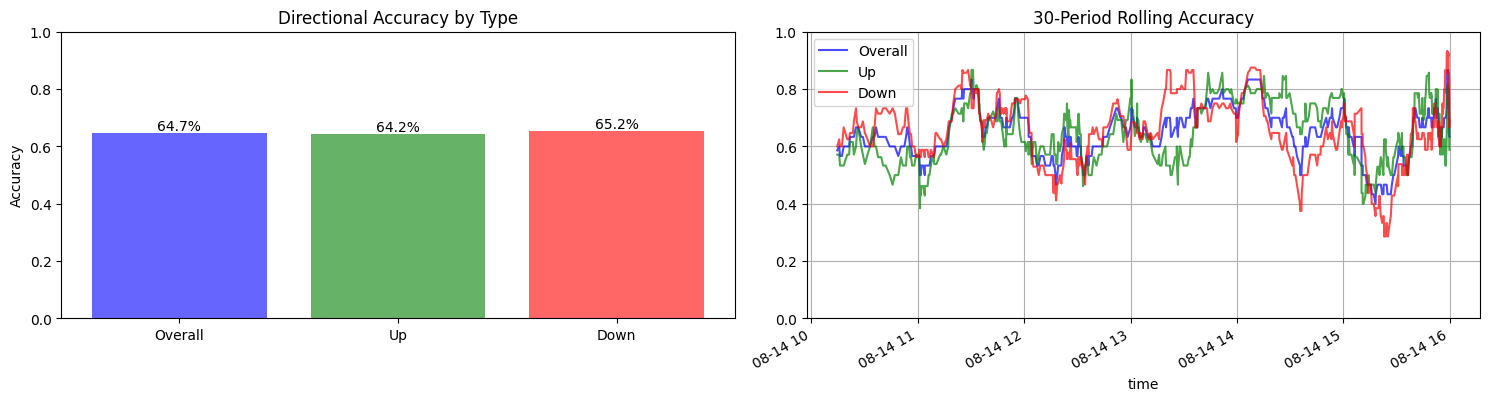

Actual: [-1.81, 1.83] | Predicted: [-1.11, 1.23]


Overall residuals: [-2.39, 2.07], std: 0.90
Up moves residuals: mean=0.42, std=0.81
Down moves residuals: mean=-0.32, std=0.83


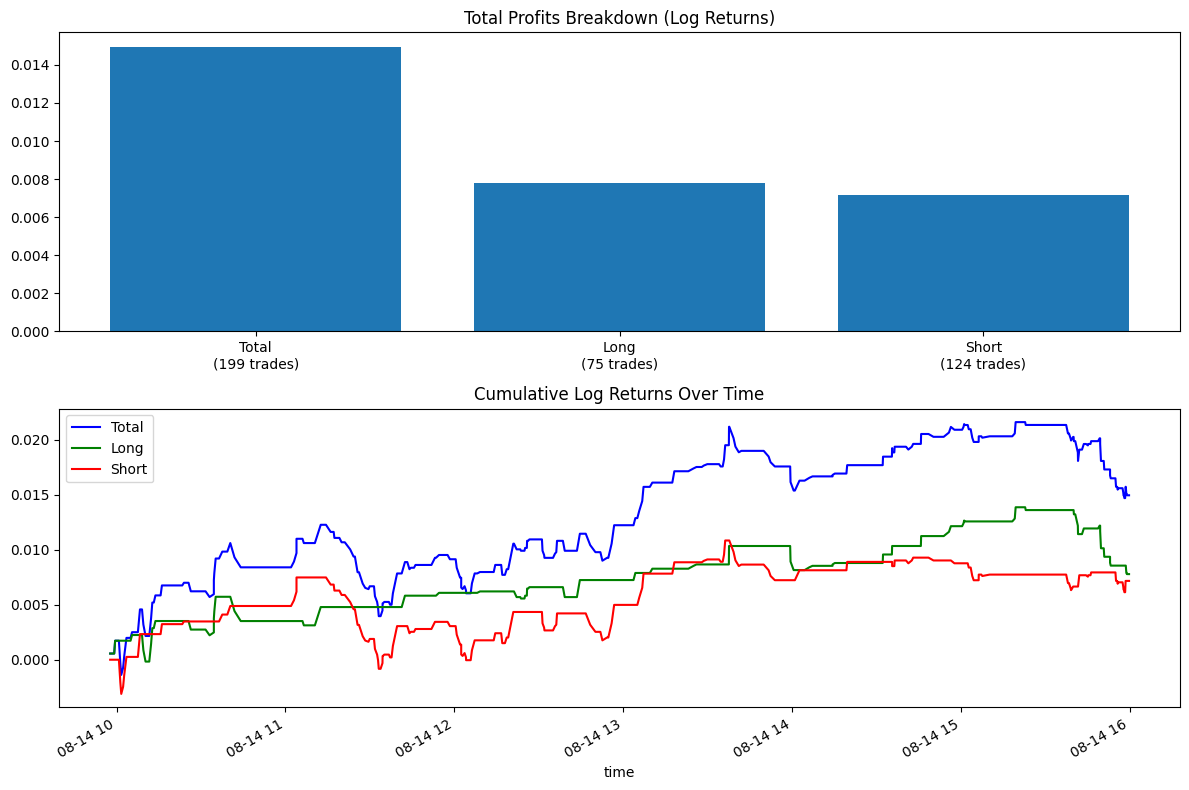


Processing iteration 1
Training: 2024-08-13 14:40:13.939645952-04:00 to 2024-08-14 15:59:59.621134080-04:00 : (897, 9)
Testing: 2024-08-14 15:06:17.946199040-04:00 to 2024-08-15 15:59:59.596648960-04:00 : (1328, 9)
Fibonacci lookbacks for 0 days 00:00:00.000001024 and lookback 0 days 02:00:00: [3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368, 75025, 121393, 196418, 317811, 514229, 832040, 1346269, 2178309, 3524578, 5702887, 9227465, 14930352, 24157817, 39088169, 63245986, 102334155, 165580141, 267914296, 433494437, 701408733, 1134903170, 1836311903, 2971215073, 4807526976]
Fibonacci windows_old: [3, 5, 8, 13, 21, 34, 55]
Features shape before dropna: (897, 117)
Percentage of valid intraday targets: 84.13%


/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/arch/univariate/base.py:768: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




Target statistics: {'mean': 0.0009777186695640759, 'std': 0.9709210669229643, 'skew': 0.011734639965630705, 'kurtosis': -1.302890694770569, 'stationarity_pvalue': 7.892945143094277e-19}
After target generation DatetimeIndex(['2024-08-13 15:39:28.606342912-04:00', '2024-08-14 15:59:59.621134080-04:00'], dtype='datetime64[ns, US/Eastern]', name='time', freq=None)
TRAIN-----
X_train shape: (775, 117) DatetimeIndex(['2024-08-13 15:39:28.606342912-04:00', '2024-08-14 15:59:59.621134080-04:00'], dtype='datetime64[ns, US/Eastern]', name='time', freq=None)
y_train shape: (775,) DatetimeIndex(['2024-08-13 15:39:28.606342912-04:00', '2024-08-14 15:59:59.621134080-04:00'], dtype='datetime64[ns, US/Eastern]', name='time', freq=None)
Removing NaNs
X_train shape after cleaning: (633, 117) DatetimeIndex(['2024-08-14 09:57:42.450324992-04:00', '2024-08-14 15:59:44.291924992-04:00'], dtype='datetime64[ns, US/Eastern]', name='time', freq=None)
y_train shape after cleaning: (633,) DatetimeIndex(['2024-08

/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/arch/univariate/base.py:768: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




Directional Accuracy Metrics:
Overall Accuracy: 70.68%
Up Movement Accuracy: 71.40%
Down Movement Accuracy: 69.98%

Total Predictions: 1037
Correct Predictions: 733
Up Movements: 514
Down Movements: 523


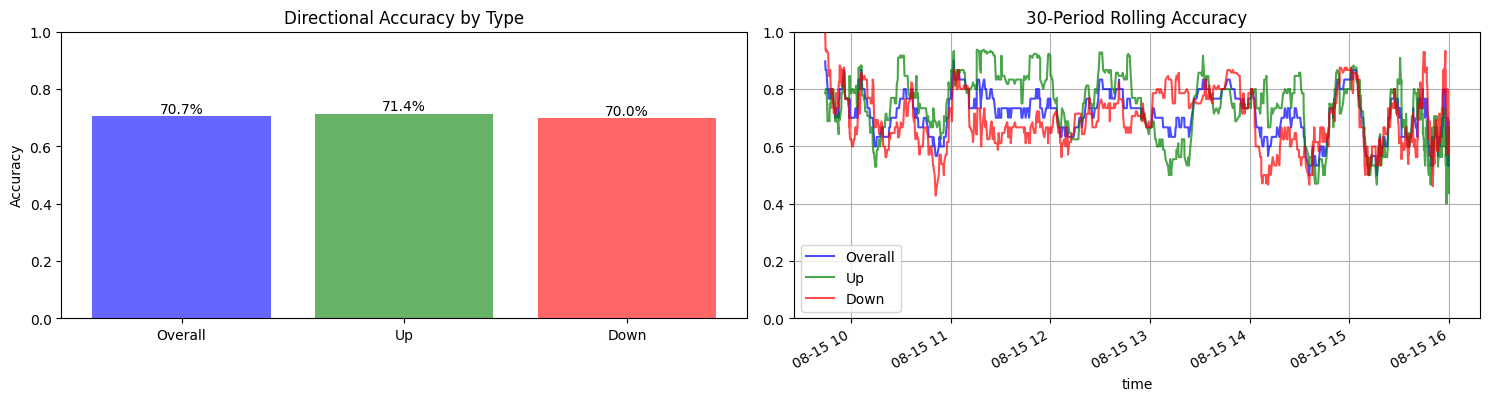

Actual: [-1.86, 1.93] | Predicted: [-1.20, 1.34]


Overall residuals: [-2.27, 2.20], std: 0.89
Up moves residuals: mean=0.40, std=0.78
Down moves residuals: mean=-0.42, std=0.80


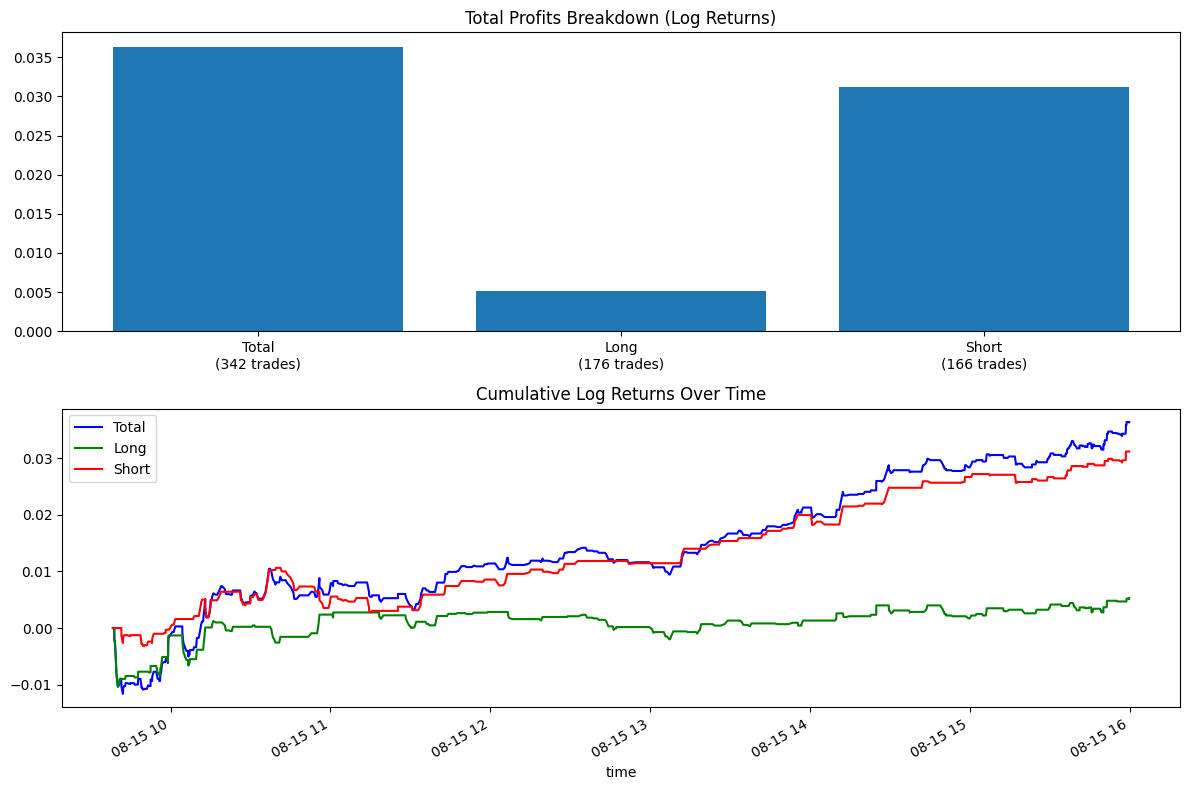


Processing iteration 2
Training: 2024-08-14 15:06:17.946199040-04:00 to 2024-08-15 15:59:59.596648960-04:00 : (1328, 9)
Testing: 2024-08-15 15:36:52.402953984-04:00 to 2024-08-16 15:59:59.978934016-04:00 : (1010, 9)
Fibonacci lookbacks for 0 days 00:00:00.000001024 and lookback 0 days 02:00:00: [3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368, 75025, 121393, 196418, 317811, 514229, 832040, 1346269, 2178309, 3524578, 5702887, 9227465, 14930352, 24157817, 39088169, 63245986, 102334155, 165580141, 267914296, 433494437, 701408733, 1134903170, 1836311903, 2971215073, 4807526976]
Fibonacci windows_old: [3, 5, 8, 13, 21, 34, 55]
Column highly correlated - maybe drop? ['high', 'low', 'price_velocity', 'volume_momentum_3s', 'sma_3s', 'volume_momentum_5s', 'sma_5s', 'volume_momentum_8s', 'sma_8s', 'volume_momentum_13s', 'sma_13s', 'volume_momentum_21s', 'sma_21s', 'volume_momentum_34s', 'volume_pressure_34s', 'sma_34s', 'volume_momentum_5

/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/arch/univariate/base.py:768: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




TEST-----
Fibonacci lookbacks for 0 days 00:00:00.000001024 and lookback 0 days 02:00:00: [3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368, 75025, 121393, 196418, 317811, 514229, 832040, 1346269, 2178309, 3524578, 5702887, 9227465, 14930352, 24157817, 39088169, 63245986, 102334155, 165580141, 267914296, 433494437, 701408733, 1134903170, 1836311903, 2971215073, 4807526976]
Fibonacci windows_old: [3, 5, 8, 13, 21, 34, 55]
Column highly correlated - maybe drop? ['high', 'low', 'price_velocity', 'sma_3s', 'sma_5s', 'avg_trade_size_8s', 'sma_8s', 'sma_13s', 'volume_pressure_21s', 'sma_21s', 'volume_pressure_34s', 'sma_34s', 'volume_pressure_55s', 'sma_55s', 'ma_5', 'ma_5_slope', 'ma_10', 'ma_20', 'ma_20_slope', 'ma_5_20_cross', 'ma_50', 'ma_5_50_cross', 'ma_momentum'] 
Features shape before dropna: (1010, 117)
Percentage of valid intraday targets: 85.30%
Target statistics: {'mean': 0.0069182665876532145, 'std': 0.9843602810642071, 'sk

/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/arch/univariate/base.py:768: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




Directional Accuracy Metrics:
Overall Accuracy: 71.18%
Up Movement Accuracy: 75.88%
Down Movement Accuracy: 66.67%

Total Predictions: 694
Correct Predictions: 494
Up Movements: 340
Down Movements: 354


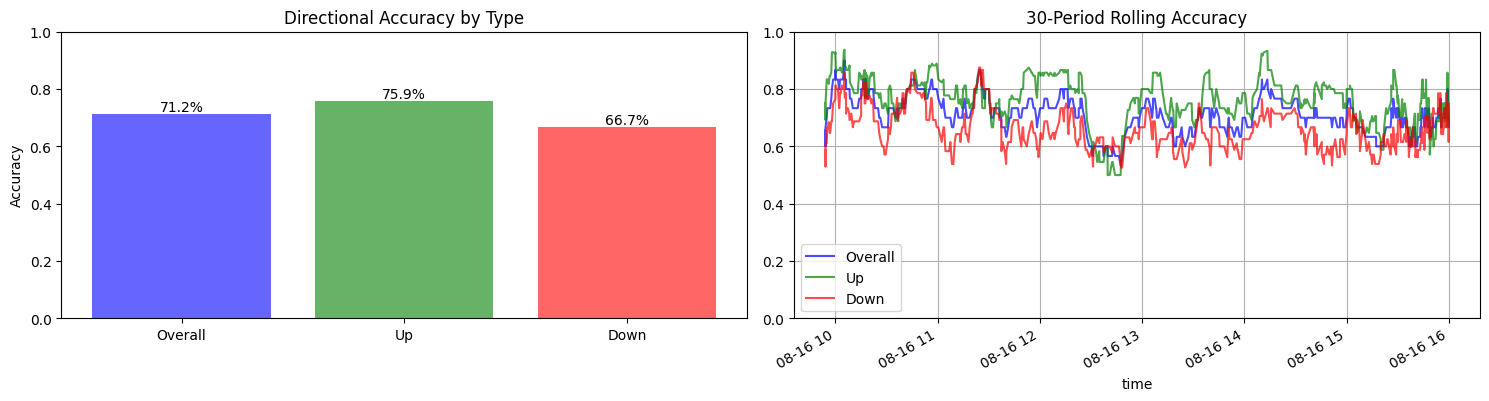

Actual: [-1.81, 2.00] | Predicted: [-1.27, 1.21]


Overall residuals: [-2.08, 2.07], std: 0.89
Up moves residuals: mean=0.41, std=0.77
Down moves residuals: mean=-0.27, std=0.87


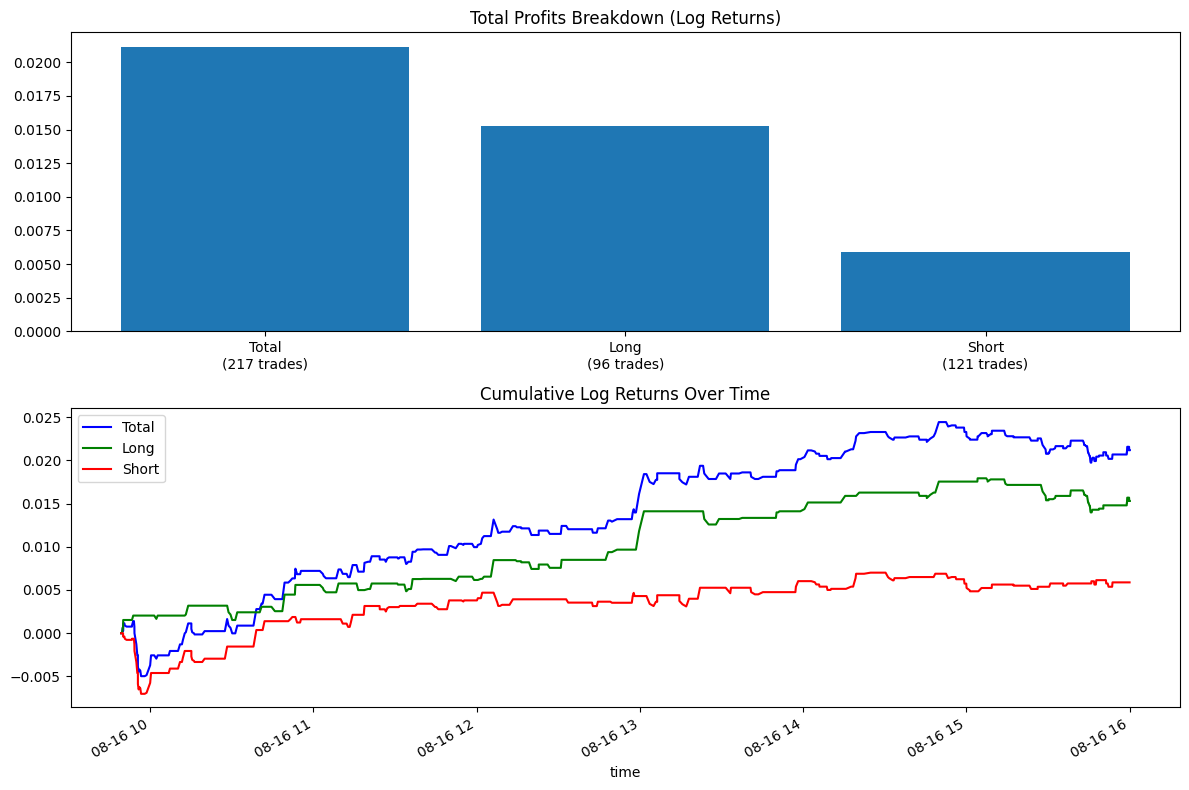

In [13]:
config = ModelConfig(
        train_days=1,
        test_days=1,
        forward_bars=5,
        model_type='regressor',
        n_classes=3,
        #ma_lengths=[5, 10, 20, 50],
        warm_up_period = 200, # Number of bars to attach before /train period
        features_fib_max_lookback = pd.Timedelta(hours=2), # maximum features lookback
        features_fib_max_windows = None, # limit features windows sizes to certain count
        optuna_trials = 1,
        summary_analysis_profit_th = 0.5,
        summary_per_iteration = True,
        summary_slippage_pct=0.0169 #pct slippage with Alpaca
)
    
feature_builder = TechnicalFeatureBuilder(config)
model = LibraryTradingModel(config=config, feature_builder=feature_builder)

results = model.run_rolling_window(df, num_iterations=3)

In [10]:
# # Regular output with all columns
# dataset = model.generate_feature_dataset(
#     df,
#     output_path='full_features_dataset.csv',
#     use_generic_features=True,
#     num_iterations=3
# )

# With metadata columns and generic feature names
dataset = model.generate_feature_dataset(
    data=df,
    output_path='features_dataset_60s.csv',
    use_generic_features=False,
    include_metadata=False,
    num_iterations=1
)

Generating features dataset with 1 windows...

Processing window 1/1
Fibonacci lookbacks for 0 days 00:01:00 and lookback 0 days 01:00:00: [3, 5, 8, 13, 21, 34, 55]
Fibonacci windows_old: [3, 5, 8, 13, 21, 34, 55]
Column highly correlated - maybe drop? ['high', 'low', 'price_velocity', 'sma_3s', 'sma_5s', 'sma_8s', 'sma_13s', 'range_21s', 'sma_21s', 'range_34s', 'sma_34s', 'range_55s', 'trade_intensity_55s', 'sma_55s', 'ma_5', 'ma_5_slope', 'ma_10', 'ma_10_slope', 'ma_5_10_cross', 'ma_20', 'ma_20_slope', 'ma_5_20_cross', 'ma_50', 'ma_5_50_cross', 'ma_momentum'] 
Features shape before dropna: (3960, 117)
Percentage of valid intraday targets: 98.73%
after target generation DatetimeIndex(['2024-08-02 10:19:00-04:00', '2024-08-15 15:59:00-04:00'], dtype='datetime64[ns, US/Eastern]', name='time', freq=None)
Fibonacci lookbacks for 0 days 00:01:00 and lookback 0 days 01:00:00: [3, 5, 8, 13, 21, 34, 55]
Fibonacci windows_old: [3, 5, 8, 13, 21, 34, 55]
Features shape before dropna: (450, 117)


Fetch 1s bars for deeper analysis

In [11]:
#This is how to call LOAD function
symbol = ["BAC"]
#datetime in zoneNY 
day_start = datetime(2024, 8, 1, 9, 30, 0)
day_stop = datetime(2024, 10, 20, 16, 0, 0)
day_start = zoneNY.localize(day_start)
day_stop = zoneNY.localize(day_stop)

#requested AGG
resolution = 1 #10min bars #12s bars
agg_type = AggType.OHLCV #other types AggType.OHLCV_VOL, AggType.OHLCV_DOL, AggType.OHLCV_RENKO
exclude_conditions = ['C','O','4','B','7','V','P','W','U','Z','F','9','M','6'] #None to defaults
minsize = 100 #min trade size to include
main_session_only = True
force_remote = False

bac_data = load_data(symbol = symbol,
                     agg_type = agg_type,
                     resolution = resolution,
                     start_date = day_start,
                     end_date = day_stop,
                     #exclude_conditions = None,
                     minsize = minsize,
                     main_session_only = main_session_only,
                     force_remote = force_remote,
                     return_vbt = True, #returns vbt object
                     verbose = True
                     )
df_secs_close = bac_data.ohlcv.data["BAC"].close



matched agg files 1

File: BAC-AggType.OHLCV-1-2024-01-01T09-30-00-2024-10-20T16-00-00-4679BCFMOPUVWZ-100-True.parquet
Coverage: 2024-01-01 09:30:00 to 2024-10-20 16:00:00
Symbol: BAC
Agg Type: AggType.OHLCV
Resolution: 1
Excludes: 4679BCFMOPUVWZ
Minsize: 100
Main Session Only: True
--------------------------------------------------------------------------------
Loaded from agg_cache /Users/davidbrazda/Library/Application Support/v2realbot/aggcache/BAC-AggType.OHLCV-1-2024-01-01T09-30-00-2024-10-20T16-00-00-4679BCFMOPUVWZ-100-True.parquet


In [12]:
for key, val in results.items():
    df = val["results"] #predicted, actual, close
    test_range = val["test_period"] #'test_period': (Timestamp('2024-08-16 00:00:00-0400', tz='US/Eastern'),Timestamp('2024-08-19 00:00:00-0400', tz='US/Eastern')),
    train_range = val["train_period"]
    test_close_secs = df_secs_close.loc[test_range[0]:test_range[1]]

    Panel(
        #auto_scale=[cdlbreakaway],
        #ohlcv=(t1data.ohlcv.data["BAC"],entries),
        histogram=[],
        right=[(df["close"],),(test_close_secs,"sec_close")],
        left=[(df["predicted"],), (df["actual"],)],
        middle1=[],
        middle2=[]
        ).chart(size="s", precision=4, title="act vs pred on 1m and 1s")

Error fetching main session


Error fetching main session


Error fetching main session


In [19]:
results

{0: {'train_period': (Timestamp('2024-08-02 00:00:00-0400', tz='US/Eastern'),
   Timestamp('2024-08-16 00:00:00-0400', tz='US/Eastern')),
  'test_period': (Timestamp('2024-08-16 00:00:00-0400', tz='US/Eastern'),
   Timestamp('2024-08-19 00:00:00-0400', tz='US/Eastern')),
  'results':                            predicted    actual   close
  time                                                  
  2024-08-16 10:38:00-04:00  -0.000019 -0.000657  39.225
  2024-08-16 10:39:00-04:00  -0.000019 -0.000430  39.235
  2024-08-16 10:40:00-04:00  -0.000019 -0.000343  39.205
  2024-08-16 10:41:00-04:00  -0.000019  0.000344  39.175
  2024-08-16 10:42:00-04:00  -0.000035 -0.000242  39.215
  ...                              ...       ...     ...
  2024-08-16 15:52:00-04:00  -0.000040 -0.000240  39.350
  2024-08-16 15:53:00-04:00  -0.000040 -0.000415  39.360
  2024-08-16 15:54:00-04:00  -0.000040 -0.000125  39.345
  2024-08-16 15:55:00-04:00  -0.000040 -0.000125  39.340
  2024-08-16 15:56:00-04:00  -0.0

In [20]:
# results[0]["model"].save_model('MODEL_60s_v3.xgb')

# # load the model from the file
# model = XGBRegressor()
# model.load_model('model.xgb')

In [ ]:
frequency = pd.Series(df.index).diff().mode()[0]